# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
# !unzip processed_celeba_small.zip
%ls

assets/                     problem_unittests.py        __pycache__/
dlnd_face_generation.ipynb  processed_celeba_small/
__MACOSX/                   processed_celeba_small.zip


In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    
    dataset = datasets.ImageFolder(data_dir, transform)
    
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 20
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

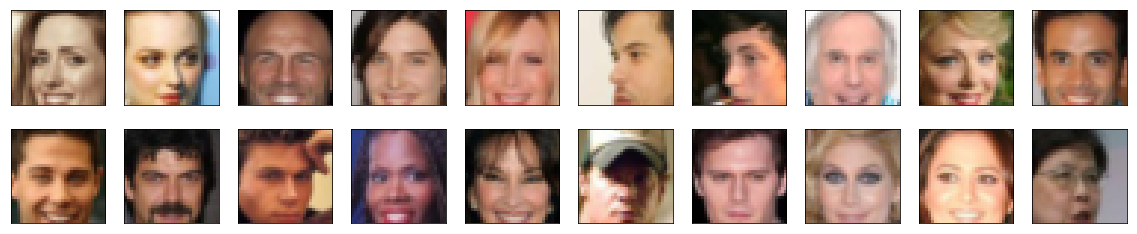

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9137)
Max:  tensor(0.9765)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
# import torch.nn as nn
# import torch.nn.functional as F


import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32): ##WARNING##
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        
        # flatten
        x = x.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        x = self.fc(x)        
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        
        # last layer + tanh activation
        x = self.t_conv3(x)
        x = F.tanh(x)
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
from torch.nn import init
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    init_gain=0.02
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    # TODO: Apply initial weights to convolutional and linear layers
    classname = m.__class__.__name__
    # print(classname)
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, init_gain)
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
        init.normal_(m.weight.data, 1.0, init_gain)
        init.constant_(m.bias.data, 0.0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [17]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [18]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            d_optimizer.zero_grad()
            
            # 1. Train the discriminator on real and fake images
            
            if train_on_gpu:
                real_images = real_images.cuda()
        
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 2. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [21]:
# set number of epochs 
n_epochs = 20


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   20] | d_loss: 0.2365 | g_loss: 3.1915
Epoch [    1/   20] | d_loss: 0.4396 | g_loss: 1.6893
Epoch [    1/   20] | d_loss: 1.1345 | g_loss: 3.9373
Epoch [    1/   20] | d_loss: 0.4373 | g_loss: 2.8390
Epoch [    1/   20] | d_loss: 0.5543 | g_loss: 2.0640
Epoch [    1/   20] | d_loss: 0.8666 | g_loss: 0.9834
Epoch [    1/   20] | d_loss: 0.4877 | g_loss: 1.9836
Epoch [    1/   20] | d_loss: 0.3440 | g_loss: 2.7662
Epoch [    1/   20] | d_loss: 0.7486 | g_loss: 1.3371
Epoch [    1/   20] | d_loss: 0.8902 | g_loss: 1.2422
Epoch [    1/   20] | d_loss: 1.1208 | g_loss: 1.1770
Epoch [    1/   20] | d_loss: 0.9346 | g_loss: 1.9360
Epoch [    1/   20] | d_loss: 1.0183 | g_loss: 1.2405
Epoch [    1/   20] | d_loss: 0.9443 | g_loss: 1.0454
Epoch [    1/   20] | d_loss: 1.0046 | g_loss: 1.1044
Epoch [    1/   20] | d_loss: 1.0667 | g_loss: 1.1759
Epoch [    1/   20] | d_loss: 0.8803 | g_loss: 1.9555
Epoch [    1/   20] | d_loss: 1.2712 | g_loss: 0.8598
Epoch [    1/   20] | d_loss

Epoch [    2/   20] | d_loss: 0.7235 | g_loss: 1.4158
Epoch [    2/   20] | d_loss: 0.4623 | g_loss: 3.2831
Epoch [    2/   20] | d_loss: 0.9199 | g_loss: 1.8490
Epoch [    2/   20] | d_loss: 0.7826 | g_loss: 1.6946
Epoch [    2/   20] | d_loss: 0.8414 | g_loss: 0.5888
Epoch [    2/   20] | d_loss: 0.4374 | g_loss: 1.7593
Epoch [    2/   20] | d_loss: 1.0092 | g_loss: 1.8535
Epoch [    2/   20] | d_loss: 1.5498 | g_loss: 1.4504
Epoch [    2/   20] | d_loss: 0.6986 | g_loss: 1.1633
Epoch [    2/   20] | d_loss: 0.7586 | g_loss: 0.8074
Epoch [    2/   20] | d_loss: 1.6364 | g_loss: 1.8338
Epoch [    2/   20] | d_loss: 1.1764 | g_loss: 2.1410
Epoch [    2/   20] | d_loss: 0.7661 | g_loss: 1.7921
Epoch [    2/   20] | d_loss: 0.6504 | g_loss: 2.0737
Epoch [    2/   20] | d_loss: 1.0725 | g_loss: 0.5367
Epoch [    2/   20] | d_loss: 0.8904 | g_loss: 1.2878
Epoch [    2/   20] | d_loss: 0.9540 | g_loss: 1.5347
Epoch [    2/   20] | d_loss: 1.2810 | g_loss: 1.7727
Epoch [    2/   20] | d_loss

Epoch [    4/   20] | d_loss: 0.6685 | g_loss: 2.7948
Epoch [    4/   20] | d_loss: 0.8060 | g_loss: 2.3607
Epoch [    4/   20] | d_loss: 0.8477 | g_loss: 1.7164
Epoch [    4/   20] | d_loss: 0.5191 | g_loss: 1.6058
Epoch [    4/   20] | d_loss: 0.5778 | g_loss: 1.3647
Epoch [    4/   20] | d_loss: 0.9445 | g_loss: 2.9639
Epoch [    4/   20] | d_loss: 0.5466 | g_loss: 1.7994
Epoch [    4/   20] | d_loss: 1.0215 | g_loss: 1.8775
Epoch [    4/   20] | d_loss: 0.7723 | g_loss: 1.1571
Epoch [    4/   20] | d_loss: 1.2024 | g_loss: 0.9948
Epoch [    4/   20] | d_loss: 1.7468 | g_loss: 0.6405
Epoch [    4/   20] | d_loss: 0.8236 | g_loss: 1.8989
Epoch [    4/   20] | d_loss: 0.3472 | g_loss: 2.1269
Epoch [    4/   20] | d_loss: 0.5911 | g_loss: 1.4982
Epoch [    4/   20] | d_loss: 0.9259 | g_loss: 1.5270
Epoch [    4/   20] | d_loss: 0.5485 | g_loss: 2.2978
Epoch [    4/   20] | d_loss: 0.8050 | g_loss: 2.1338
Epoch [    4/   20] | d_loss: 0.9255 | g_loss: 2.1417
Epoch [    4/   20] | d_loss

Epoch [    6/   20] | d_loss: 0.3950 | g_loss: 1.9838
Epoch [    6/   20] | d_loss: 0.6020 | g_loss: 2.5078
Epoch [    6/   20] | d_loss: 0.6569 | g_loss: 2.8703
Epoch [    6/   20] | d_loss: 2.2291 | g_loss: 1.7917
Epoch [    6/   20] | d_loss: 0.4797 | g_loss: 2.9608
Epoch [    6/   20] | d_loss: 0.9908 | g_loss: 3.3435
Epoch [    6/   20] | d_loss: 0.7189 | g_loss: 1.6175
Epoch [    6/   20] | d_loss: 0.4614 | g_loss: 2.2231
Epoch [    6/   20] | d_loss: 0.8896 | g_loss: 2.1209
Epoch [    6/   20] | d_loss: 0.4692 | g_loss: 2.5227
Epoch [    6/   20] | d_loss: 0.6741 | g_loss: 2.8665
Epoch [    6/   20] | d_loss: 0.4083 | g_loss: 1.9145
Epoch [    6/   20] | d_loss: 0.7607 | g_loss: 1.7462
Epoch [    6/   20] | d_loss: 0.4950 | g_loss: 1.7371
Epoch [    6/   20] | d_loss: 0.4183 | g_loss: 1.5651
Epoch [    6/   20] | d_loss: 1.3648 | g_loss: 0.9323
Epoch [    6/   20] | d_loss: 0.4415 | g_loss: 2.5760
Epoch [    6/   20] | d_loss: 0.6798 | g_loss: 2.1891
Epoch [    6/   20] | d_loss

Epoch [    7/   20] | d_loss: 0.3791 | g_loss: 1.9184
Epoch [    7/   20] | d_loss: 0.4791 | g_loss: 1.8308
Epoch [    7/   20] | d_loss: 1.0330 | g_loss: 5.0259
Epoch [    7/   20] | d_loss: 0.5677 | g_loss: 1.5612
Epoch [    7/   20] | d_loss: 0.4719 | g_loss: 2.1885
Epoch [    7/   20] | d_loss: 0.4150 | g_loss: 2.9447
Epoch [    7/   20] | d_loss: 0.3295 | g_loss: 2.2838
Epoch [    7/   20] | d_loss: 0.5492 | g_loss: 3.9088
Epoch [    7/   20] | d_loss: 0.3415 | g_loss: 2.0380
Epoch [    7/   20] | d_loss: 0.5938 | g_loss: 1.6298
Epoch [    7/   20] | d_loss: 0.3296 | g_loss: 2.4099
Epoch [    7/   20] | d_loss: 0.2367 | g_loss: 1.5723
Epoch [    7/   20] | d_loss: 0.3365 | g_loss: 2.0597
Epoch [    7/   20] | d_loss: 0.3752 | g_loss: 2.0819
Epoch [    7/   20] | d_loss: 0.4012 | g_loss: 2.8685
Epoch [    7/   20] | d_loss: 0.3358 | g_loss: 2.9789
Epoch [    7/   20] | d_loss: 0.3948 | g_loss: 2.8956
Epoch [    7/   20] | d_loss: 0.3849 | g_loss: 3.3836
Epoch [    7/   20] | d_loss

Epoch [    9/   20] | d_loss: 0.2217 | g_loss: 3.8002
Epoch [    9/   20] | d_loss: 0.3861 | g_loss: 2.8599
Epoch [    9/   20] | d_loss: 0.3459 | g_loss: 1.3781
Epoch [    9/   20] | d_loss: 0.3617 | g_loss: 1.6928
Epoch [    9/   20] | d_loss: 0.5458 | g_loss: 2.1800
Epoch [    9/   20] | d_loss: 0.1720 | g_loss: 1.7553
Epoch [    9/   20] | d_loss: 0.3634 | g_loss: 2.3227
Epoch [    9/   20] | d_loss: 0.2200 | g_loss: 3.7557
Epoch [    9/   20] | d_loss: 0.2279 | g_loss: 3.3444
Epoch [    9/   20] | d_loss: 0.7111 | g_loss: 4.2474
Epoch [    9/   20] | d_loss: 1.0527 | g_loss: 3.4739
Epoch [    9/   20] | d_loss: 0.9473 | g_loss: 3.5593
Epoch [    9/   20] | d_loss: 0.5566 | g_loss: 3.6466
Epoch [    9/   20] | d_loss: 0.5753 | g_loss: 3.2165
Epoch [    9/   20] | d_loss: 0.4503 | g_loss: 5.0296
Epoch [    9/   20] | d_loss: 0.7191 | g_loss: 1.3318
Epoch [    9/   20] | d_loss: 0.3186 | g_loss: 2.9175
Epoch [    9/   20] | d_loss: 0.4055 | g_loss: 3.2338
Epoch [    9/   20] | d_loss

Epoch [   11/   20] | d_loss: 0.1761 | g_loss: 4.0376
Epoch [   11/   20] | d_loss: 2.6286 | g_loss: 3.2244
Epoch [   11/   20] | d_loss: 0.1658 | g_loss: 3.1471
Epoch [   11/   20] | d_loss: 0.2740 | g_loss: 2.6653
Epoch [   11/   20] | d_loss: 0.3634 | g_loss: 2.9376
Epoch [   11/   20] | d_loss: 0.3026 | g_loss: 4.4493
Epoch [   11/   20] | d_loss: 0.4376 | g_loss: 4.1861
Epoch [   11/   20] | d_loss: 0.2001 | g_loss: 3.3485
Epoch [   11/   20] | d_loss: 0.4469 | g_loss: 3.6063
Epoch [   11/   20] | d_loss: 0.3226 | g_loss: 4.0898
Epoch [   11/   20] | d_loss: 0.7237 | g_loss: 2.4981
Epoch [   11/   20] | d_loss: 0.5669 | g_loss: 3.9289
Epoch [   11/   20] | d_loss: 0.4085 | g_loss: 3.3577
Epoch [   11/   20] | d_loss: 0.8422 | g_loss: 2.0453
Epoch [   11/   20] | d_loss: 0.3128 | g_loss: 2.6177
Epoch [   11/   20] | d_loss: 0.1987 | g_loss: 3.2683
Epoch [   11/   20] | d_loss: 0.1461 | g_loss: 3.4866
Epoch [   11/   20] | d_loss: 0.8275 | g_loss: 2.5407
Epoch [   11/   20] | d_loss

Epoch [   12/   20] | d_loss: 0.9192 | g_loss: 2.8178
Epoch [   12/   20] | d_loss: 0.3958 | g_loss: 2.0345
Epoch [   12/   20] | d_loss: 0.1218 | g_loss: 2.8642
Epoch [   12/   20] | d_loss: 0.5273 | g_loss: 3.9734
Epoch [   12/   20] | d_loss: 0.1563 | g_loss: 3.0673
Epoch [   12/   20] | d_loss: 0.1668 | g_loss: 3.6285
Epoch [   12/   20] | d_loss: 0.1690 | g_loss: 4.1695
Epoch [   12/   20] | d_loss: 0.1407 | g_loss: 3.8502
Epoch [   12/   20] | d_loss: 1.0982 | g_loss: 1.3849
Epoch [   12/   20] | d_loss: 0.2070 | g_loss: 2.6852
Epoch [   12/   20] | d_loss: 0.1172 | g_loss: 4.1524
Epoch [   12/   20] | d_loss: 0.0938 | g_loss: 2.3020
Epoch [   12/   20] | d_loss: 0.2873 | g_loss: 3.0739
Epoch [   12/   20] | d_loss: 0.5463 | g_loss: 3.5236
Epoch [   12/   20] | d_loss: 0.4490 | g_loss: 2.7050
Epoch [   12/   20] | d_loss: 0.2086 | g_loss: 3.3444
Epoch [   13/   20] | d_loss: 0.3886 | g_loss: 3.9842
Epoch [   13/   20] | d_loss: 0.2917 | g_loss: 3.9184
Epoch [   13/   20] | d_loss

Epoch [   14/   20] | d_loss: 0.6385 | g_loss: 3.4863
Epoch [   14/   20] | d_loss: 0.1679 | g_loss: 5.8229
Epoch [   14/   20] | d_loss: 0.2251 | g_loss: 4.2688
Epoch [   14/   20] | d_loss: 0.2338 | g_loss: 3.9389
Epoch [   14/   20] | d_loss: 0.0815 | g_loss: 4.0560
Epoch [   14/   20] | d_loss: 0.4834 | g_loss: 4.0564
Epoch [   14/   20] | d_loss: 0.7169 | g_loss: 4.1574
Epoch [   14/   20] | d_loss: 0.5321 | g_loss: 4.5182
Epoch [   14/   20] | d_loss: 0.1893 | g_loss: 2.8061
Epoch [   14/   20] | d_loss: 0.0403 | g_loss: 3.8501
Epoch [   14/   20] | d_loss: 0.5757 | g_loss: 2.6329
Epoch [   14/   20] | d_loss: 0.2714 | g_loss: 3.1190
Epoch [   14/   20] | d_loss: 0.1803 | g_loss: 5.6272
Epoch [   14/   20] | d_loss: 0.3263 | g_loss: 2.4841
Epoch [   14/   20] | d_loss: 0.3753 | g_loss: 2.5000
Epoch [   14/   20] | d_loss: 0.1807 | g_loss: 4.3493
Epoch [   14/   20] | d_loss: 0.0917 | g_loss: 6.2100
Epoch [   14/   20] | d_loss: 0.1912 | g_loss: 4.1464
Epoch [   14/   20] | d_loss

Epoch [   16/   20] | d_loss: 0.2115 | g_loss: 3.6842
Epoch [   16/   20] | d_loss: 0.2599 | g_loss: 4.3217
Epoch [   16/   20] | d_loss: 0.1335 | g_loss: 3.9105
Epoch [   16/   20] | d_loss: 0.3270 | g_loss: 4.5007
Epoch [   16/   20] | d_loss: 0.3368 | g_loss: 2.7356
Epoch [   16/   20] | d_loss: 0.5415 | g_loss: 2.6548
Epoch [   16/   20] | d_loss: 0.1956 | g_loss: 3.8569
Epoch [   16/   20] | d_loss: 0.0560 | g_loss: 2.5223
Epoch [   16/   20] | d_loss: 0.1078 | g_loss: 5.0272
Epoch [   16/   20] | d_loss: 0.2157 | g_loss: 3.2940
Epoch [   16/   20] | d_loss: 0.6006 | g_loss: 3.5863
Epoch [   16/   20] | d_loss: 0.7187 | g_loss: 3.5945
Epoch [   16/   20] | d_loss: 0.2283 | g_loss: 3.7905
Epoch [   16/   20] | d_loss: 0.3545 | g_loss: 2.2893
Epoch [   16/   20] | d_loss: 0.1336 | g_loss: 2.9846
Epoch [   16/   20] | d_loss: 0.7323 | g_loss: 3.5847
Epoch [   16/   20] | d_loss: 0.2519 | g_loss: 2.7031
Epoch [   16/   20] | d_loss: 0.2671 | g_loss: 4.0523
Epoch [   16/   20] | d_loss

Epoch [   17/   20] | d_loss: 1.9368 | g_loss: 2.6526
Epoch [   17/   20] | d_loss: 0.1629 | g_loss: 4.3036
Epoch [   17/   20] | d_loss: 0.3507 | g_loss: 4.3032
Epoch [   17/   20] | d_loss: 0.8077 | g_loss: 1.1128
Epoch [   17/   20] | d_loss: 0.1760 | g_loss: 4.7209
Epoch [   17/   20] | d_loss: 0.3794 | g_loss: 4.9911
Epoch [   17/   20] | d_loss: 0.2748 | g_loss: 6.5700
Epoch [   17/   20] | d_loss: 0.2761 | g_loss: 2.5798
Epoch [   17/   20] | d_loss: 0.3298 | g_loss: 2.6190
Epoch [   17/   20] | d_loss: 0.2226 | g_loss: 3.6561
Epoch [   18/   20] | d_loss: 0.1208 | g_loss: 6.8912
Epoch [   18/   20] | d_loss: 0.0688 | g_loss: 4.2858
Epoch [   18/   20] | d_loss: 0.1771 | g_loss: 6.8961
Epoch [   18/   20] | d_loss: 0.1324 | g_loss: 6.1859
Epoch [   18/   20] | d_loss: 0.5156 | g_loss: 3.8458
Epoch [   18/   20] | d_loss: 0.2039 | g_loss: 3.1051
Epoch [   18/   20] | d_loss: 0.1747 | g_loss: 2.7295
Epoch [   18/   20] | d_loss: 0.1017 | g_loss: 6.0752
Epoch [   18/   20] | d_loss

Epoch [   19/   20] | d_loss: 0.0557 | g_loss: 2.7122
Epoch [   19/   20] | d_loss: 0.2408 | g_loss: 2.2529
Epoch [   19/   20] | d_loss: 0.5200 | g_loss: 1.9400
Epoch [   19/   20] | d_loss: 0.4057 | g_loss: 6.6073
Epoch [   19/   20] | d_loss: 0.1106 | g_loss: 5.3429
Epoch [   19/   20] | d_loss: 0.3764 | g_loss: 4.8844
Epoch [   19/   20] | d_loss: 0.0922 | g_loss: 3.5224
Epoch [   19/   20] | d_loss: 0.1254 | g_loss: 1.6633
Epoch [   19/   20] | d_loss: 0.2317 | g_loss: 4.5787
Epoch [   19/   20] | d_loss: 0.3422 | g_loss: 3.7084
Epoch [   19/   20] | d_loss: 0.2594 | g_loss: 4.0434
Epoch [   19/   20] | d_loss: 0.1125 | g_loss: 5.6821
Epoch [   19/   20] | d_loss: 0.1278 | g_loss: 4.1033
Epoch [   19/   20] | d_loss: 0.0496 | g_loss: 4.3552
Epoch [   19/   20] | d_loss: 0.2567 | g_loss: 4.9917
Epoch [   19/   20] | d_loss: 0.3581 | g_loss: 3.1780
Epoch [   19/   20] | d_loss: 0.0513 | g_loss: 3.8131
Epoch [   19/   20] | d_loss: 0.6640 | g_loss: 4.7886
Epoch [   19/   20] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

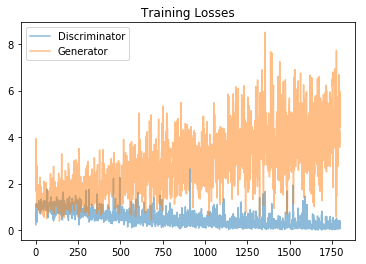

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [23]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [24]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

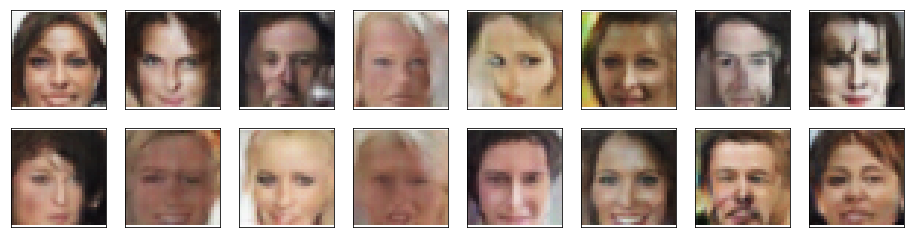

In [25]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** I notice that the generated images seems to be created like a puzzle of different faces, I think this may improve with a longer training and using images with higger resolution. Also is important to note that all the AI models behaviour is related with the data of trainig. Here we can see that there are mostly data of white people. So this means that the model won't be able to generate faces of people with different skin color. Adding this data will prevent bias.   

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.